------------
# Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

np.set_printoptions(threshold=np.inf)

---------------
# Loading Data into System

In [2]:
cgm_df = pd.read_csv(os.path.join('data','CGMData.csv')).T
bolus_df = pd.read_csv(os.path.join('data','BolusData.csv')).T

In [3]:
cgm_df = cgm_df.reset_index(drop=True)
bolus_df = bolus_df.reset_index(drop=True)

In [4]:
cgm_df.T

,0,1,2,3,4,5,6,7,8,9,...,44835,44836,44837,44838,44839,44840,44841,44842,44843,44844
0,136.0,135.0,136.0,135.0,134.0,133.0,130.0,129.0,127.0,126.0,...,100.0,100.0,100.0,101.0,102.0,101.0,98.0,95.0,91.0,89.0


In [5]:
bolus_df.T

,0,1,2,3,4,5,6,7,8,9,...,39168,39169,39170,39171,39172,39173,39174,39175,39176,39177
0,0.08,NaN,NaN,0.08,0.1,0.13,0.13,0.1,0.1,0.08,...,NaN,NaN,NaN,NaN,0.03,NaN,NaN,NaN,NaN,NaN


------------------
# Visualizing Data

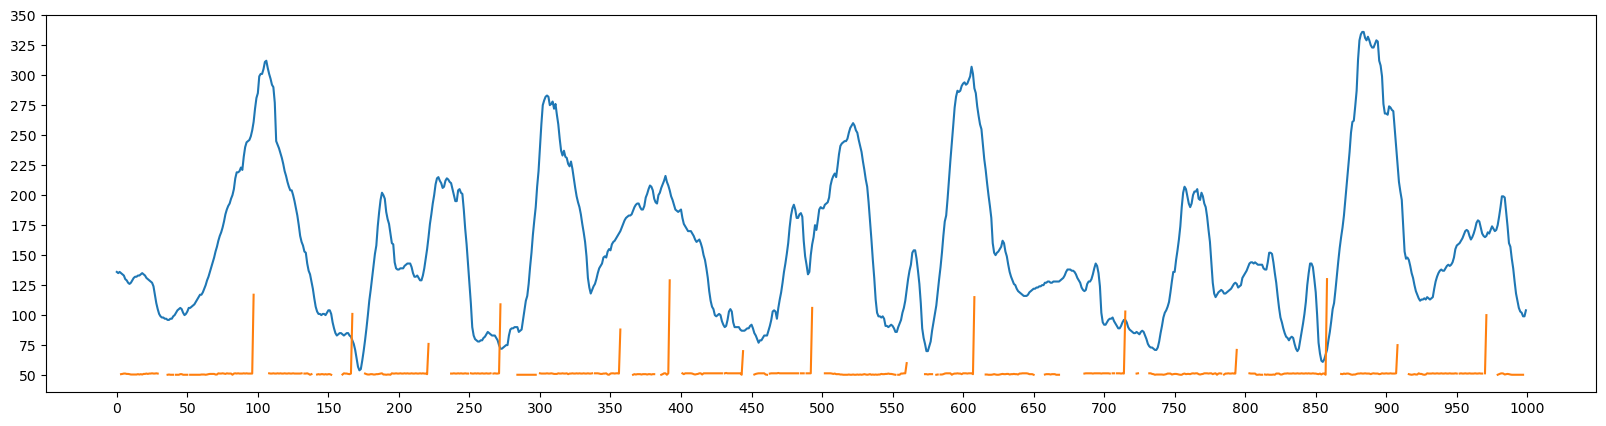

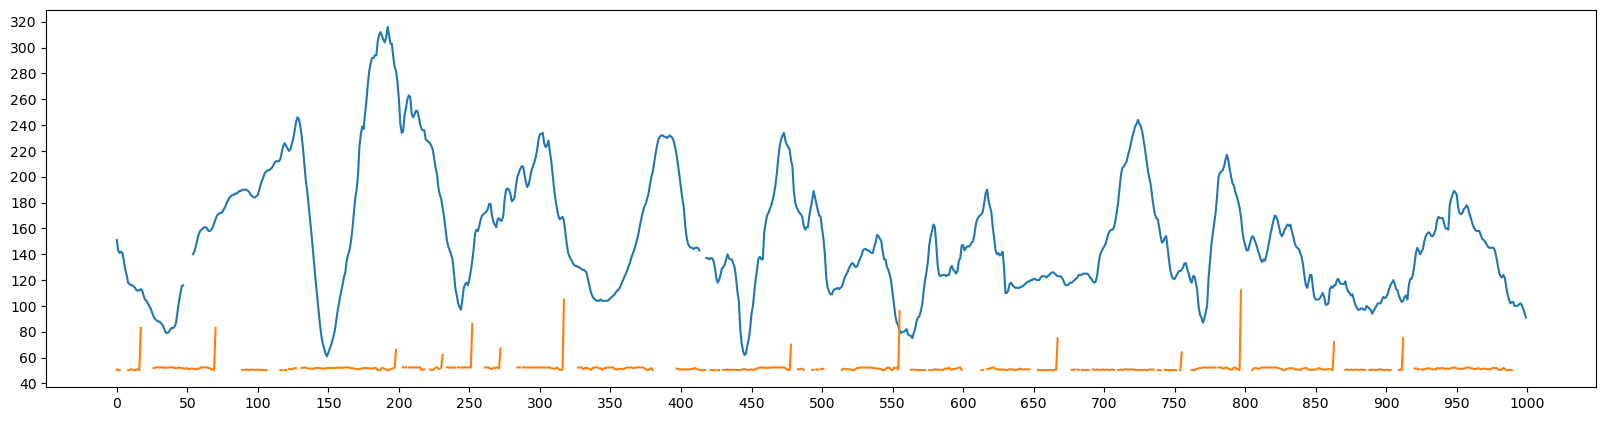

In [6]:
#max_nums = len(cgm_df[[0]])
max_nums = 1000
plt.figure(num=None, figsize=(20, 5), dpi=100)
plt.plot(list(range(max_nums)), cgm_df[[0]][:max_nums])
plt.plot(list(range(max_nums)), (bolus_df[[0]][:max_nums]*10)+50)
plt.locator_params(axis='y', nbins=15)
plt.locator_params(axis='x', nbins=25)
plt.show()

plt.figure(num=None, figsize=(20, 5), dpi=100)
plt.plot(list(range(max_nums)), cgm_df[[0]][-1*max_nums-1:-1])
plt.plot(list(range(max_nums)), (bolus_df[[0]][-1*max_nums-1:-1]*10)+50)
plt.locator_params(axis='y', nbins=15)
plt.locator_params(axis='x', nbins=25)
plt.show()

Showcasing the starting and last part of data to understand if the train and test sets are similar. The bolus data is transformed to a scale that helps with the visualization 

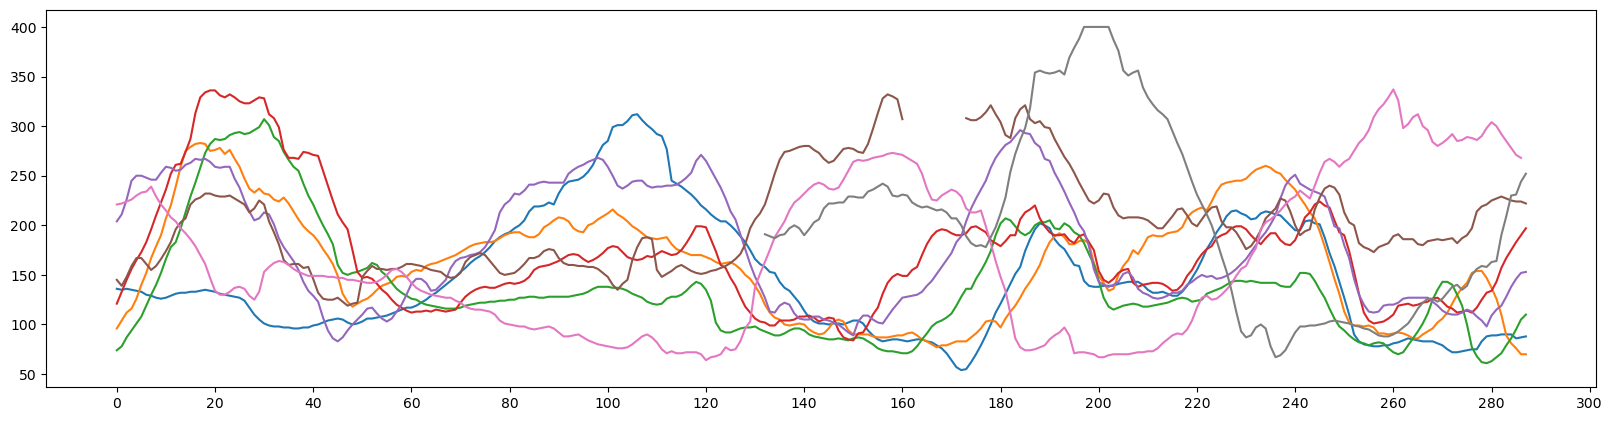

In [7]:
#max_nums = len(cgm_df[[0]])
time_stamps = (24*60)//5
days = 8
bias = 0

plt.figure(num=None, figsize=(20, 5), dpi=100)
for i in range(1, days+1):
    plt.plot(list(range(time_stamps)), cgm_df[[0]][(i-1)*(time_stamps)+bias:i*time_stamps+bias])

plt.locator_params(axis='y', nbins=15)
plt.locator_params(axis='x', nbins=25)
plt.show()

Understanding if there is any seasonality in the data and also if there exists any shift in variance thus needing a power transform to make the distribution more-normal.

------------
# PreProcessing

### Analysing NA values in CGM data

In [8]:
np.array(range(len(cgm_df)))[cgm_df.isna().any(axis=1)]

array([ 1601,  1602,  1603,  1604,  1605,  1606,  1607,  1608,  1609,
        1610,  1611,  1612,  2015,  2016,  2017,  2018,  2019,  2020,
        2021,  2022,  2023,  2024,  2025,  2026,  2027,  2028,  2029,
        2030,  2031,  2032,  2033,  2034,  2035,  2036,  2037,  2038,
        2039,  2040,  2041,  2042,  2043,  2044,  2045,  2046,  2047,
        2048,  2049,  2050,  2051,  2052,  2053,  2054,  2055,  2056,
        2057,  2058,  2059,  2060,  2061,  2062,  2063,  2064,  2065,
        2066,  2067,  2068,  2069,  2070,  2071,  2072,  2073,  2074,
        2075,  2076,  2077,  2078,  2079,  2080,  2081,  2082,  2083,
        2084,  2085,  2086,  2087,  2088,  2089,  2090,  2091,  2092,
        2093,  2094,  2095,  2096,  2097,  2098,  2099,  2100,  2101,
        2102,  2103,  2104,  2105,  2106,  2107,  2108,  2109,  2110,
        2111,  2112,  2113,  2114,  2115,  2116,  2117,  2118,  2119,
        2120,  2121,  2122,  2123,  2124,  2125,  2126,  2127,  2128,
        2129,  2130,

There are consecutive hours of missing data, Using any technique to fill these values wouldnt be a wise path to go on. Thus, we choose to ignore such missing timesequences by removing them in a later stage

### Creating Timesequence Samples

In [9]:
def get_moving_timeshift(values, time_stamps = 48, remove_na = False):
    df = pd.DataFrame(values)
    columns = columns = [df.shift(i) for i in range(time_stamps, -1, -1)]

    entire_data = pd.concat(columns, axis=1)
    entire_data.columns = list(range(0, time_stamps+1))
    if remove_na:
        entire_data = entire_data.dropna(how='any', axis=0)
    
    return entire_data.to_numpy()

In [10]:
data = pd.DataFrame(get_moving_timeshift(cgm_df.to_numpy(), remove_na = True))
data

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,136.0,135.0,136.0,135.0,134.0,133.0,130.0,129.0,127.0,126.0,...,97.0,99.0,100.0,102.0,104.0,105.0,106.0,105.0,102.0,100.0
1,135.0,136.0,135.0,134.0,133.0,130.0,129.0,127.0,126.0,127.0,...,99.0,100.0,102.0,104.0,105.0,106.0,105.0,102.0,100.0,101.0
2,136.0,135.0,134.0,133.0,130.0,129.0,127.0,126.0,127.0,129.0,...,100.0,102.0,104.0,105.0,106.0,105.0,102.0,100.0,101.0,103.0
3,135.0,134.0,133.0,130.0,129.0,127.0,126.0,127.0,129.0,131.0,...,102.0,104.0,105.0,106.0,105.0,102.0,100.0,101.0,103.0,106.0
4,134.0,133.0,130.0,129.0,127.0,126.0,127.0,129.0,131.0,132.0,...,104.0,105.0,106.0,105.0,102.0,100.0,101.0,103.0,106.0,106.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39817,189.0,188.0,186.0,176.0,172.0,171.0,172.0,175.0,176.0,178.0,...,105.0,102.0,103.0,103.0,100.0,100.0,100.0,101.0,102.0,101.0
39818,188.0,186.0,176.0,172.0,171.0,172.0,175.0,176.0,178.0,176.0,...,102.0,103.0,103.0,100.0,100.0,100.0,101.0,102.0,101.0,98.0
39819,186.0,176.0,172.0,171.0,172.0,175.0,176.0,178.0,176.0,171.0,...,103.0,103.0,100.0,100.0,100.0,101.0,102.0,101.0,98.0,95.0
39820,176.0,172.0,171.0,172.0,175.0,176.0,178.0,176.0,171.0,168.0,...,103.0,100.0,100.0,100.0,101.0,102.0,101.0,98.0,95.0,91.0


### Rescaling Data

In [11]:
print(np.nanmin(cgm_df.to_numpy(), axis=0), np.nanmax(cgm_df.to_numpy(), axis=0))

[40.] [400.]


In [12]:
def rescaling(value, newscale=(0,1), oldscale=(20,500)):
    (old_min, old_max) = oldscale
    (new_min, new_max) = newscale
    
    new_value= (new_max-new_min)/(old_max-old_min)*(value-old_max)+new_max
    
    return new_value

In [13]:
data = pd.DataFrame(np.vectorize(rescaling)(data.to_numpy()))
data

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,0.241667,0.239583,0.241667,0.239583,0.237500,0.235417,0.229167,0.227083,0.222917,0.220833,...,0.160417,0.164583,0.166667,0.170833,0.175000,0.177083,0.179167,0.177083,0.170833,0.166667
1,0.239583,0.241667,0.239583,0.237500,0.235417,0.229167,0.227083,0.222917,0.220833,0.222917,...,0.164583,0.166667,0.170833,0.175000,0.177083,0.179167,0.177083,0.170833,0.166667,0.168750
2,0.241667,0.239583,0.237500,0.235417,0.229167,0.227083,0.222917,0.220833,0.222917,0.227083,...,0.166667,0.170833,0.175000,0.177083,0.179167,0.177083,0.170833,0.166667,0.168750,0.172917
3,0.239583,0.237500,0.235417,0.229167,0.227083,0.222917,0.220833,0.222917,0.227083,0.231250,...,0.170833,0.175000,0.177083,0.179167,0.177083,0.170833,0.166667,0.168750,0.172917,0.179167
4,0.237500,0.235417,0.229167,0.227083,0.222917,0.220833,0.222917,0.227083,0.231250,0.233333,...,0.175000,0.177083,0.179167,0.177083,0.170833,0.166667,0.168750,0.172917,0.179167,0.179167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39817,0.352083,0.350000,0.345833,0.325000,0.316667,0.314583,0.316667,0.322917,0.325000,0.329167,...,0.177083,0.170833,0.172917,0.172917,0.166667,0.166667,0.166667,0.168750,0.170833,0.168750
39818,0.350000,0.345833,0.325000,0.316667,0.314583,0.316667,0.322917,0.325000,0.329167,0.325000,...,0.170833,0.172917,0.172917,0.166667,0.166667,0.166667,0.168750,0.170833,0.168750,0.162500
39819,0.345833,0.325000,0.316667,0.314583,0.316667,0.322917,0.325000,0.329167,0.325000,0.314583,...,0.172917,0.172917,0.166667,0.166667,0.166667,0.168750,0.170833,0.168750,0.162500,0.156250
39820,0.325000,0.316667,0.314583,0.316667,0.322917,0.325000,0.329167,0.325000,0.314583,0.308333,...,0.172917,0.166667,0.166667,0.166667,0.168750,0.170833,0.168750,0.162500,0.156250,0.147917


### Removing Trends

In [14]:
def get_moving_diff(values, replace_na=False):
    df = pd.DataFrame(values)
    diff_X = df.diff(axis=1)
    
    if replace_na:
        diff_X = diff_X.fillna(0.0)
    else:
        diff_X = diff_X.dropna(axis=1)
    
    return diff_X.to_numpy()

In [15]:
data = pd.DataFrame(get_moving_diff(data.to_numpy(), replace_na = True))
data

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,0.0,-0.002083,0.002083,-0.002083,-0.002083,-0.002083,-0.006250,-0.002083,-0.004167,-0.002083,...,0.000000,0.004167,0.002083,0.004167,0.004167,0.002083,0.002083,-0.002083,-0.006250,-0.004167
1,0.0,0.002083,-0.002083,-0.002083,-0.002083,-0.006250,-0.002083,-0.004167,-0.002083,0.002083,...,0.004167,0.002083,0.004167,0.004167,0.002083,0.002083,-0.002083,-0.006250,-0.004167,0.002083
2,0.0,-0.002083,-0.002083,-0.002083,-0.006250,-0.002083,-0.004167,-0.002083,0.002083,0.004167,...,0.002083,0.004167,0.004167,0.002083,0.002083,-0.002083,-0.006250,-0.004167,0.002083,0.004167
3,0.0,-0.002083,-0.002083,-0.006250,-0.002083,-0.004167,-0.002083,0.002083,0.004167,0.004167,...,0.004167,0.004167,0.002083,0.002083,-0.002083,-0.006250,-0.004167,0.002083,0.004167,0.006250
4,0.0,-0.002083,-0.006250,-0.002083,-0.004167,-0.002083,0.002083,0.004167,0.004167,0.002083,...,0.004167,0.002083,0.002083,-0.002083,-0.006250,-0.004167,0.002083,0.004167,0.006250,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39817,0.0,-0.002083,-0.004167,-0.020833,-0.008333,-0.002083,0.002083,0.006250,0.002083,0.004167,...,-0.008333,-0.006250,0.002083,0.000000,-0.006250,0.000000,0.000000,0.002083,0.002083,-0.002083
39818,0.0,-0.004167,-0.020833,-0.008333,-0.002083,0.002083,0.006250,0.002083,0.004167,-0.004167,...,-0.006250,0.002083,0.000000,-0.006250,0.000000,0.000000,0.002083,0.002083,-0.002083,-0.006250
39819,0.0,-0.020833,-0.008333,-0.002083,0.002083,0.006250,0.002083,0.004167,-0.004167,-0.010417,...,0.002083,0.000000,-0.006250,0.000000,0.000000,0.002083,0.002083,-0.002083,-0.006250,-0.006250
39820,0.0,-0.008333,-0.002083,0.002083,0.006250,0.002083,0.004167,-0.004167,-0.010417,-0.006250,...,0.000000,-0.006250,0.000000,0.000000,0.002083,0.002083,-0.002083,-0.006250,-0.006250,-0.008333


### Get Splits

In [16]:
def get_splits(values, split_per=0.8):
    df = pd.DataFrame(values)
    columns = len(df.columns)
    
    train_size = int(len(df) * split_per)
    test_size = len(df) - train_size
    train, test = df.iloc[:train_size], df.iloc[train_size:]
    
    x_train, y_train = train.iloc[:,0:columns-1], train.iloc[:,columns-1]
    x_test, y_test = test.iloc[:,0:columns-1], test.iloc[:,columns-1]
    
    return (x_train.to_numpy(), y_train.to_numpy()), (x_test.to_numpy(), y_test.to_numpy())

In [17]:
(x_lstm_train, y_train), (x_lstm_val, y_val) = get_splits(data.to_numpy())

In [18]:
pd.DataFrame(x_lstm_train)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.0,-0.002083,0.002083,-0.002083,-0.002083,-0.002083,-0.006250,-0.002083,-0.004167,-0.002083,...,0.002083,0.000000,0.004167,0.002083,0.004167,0.004167,0.002083,0.002083,-0.002083,-0.006250
1,0.0,0.002083,-0.002083,-0.002083,-0.002083,-0.006250,-0.002083,-0.004167,-0.002083,0.002083,...,0.000000,0.004167,0.002083,0.004167,0.004167,0.002083,0.002083,-0.002083,-0.006250,-0.004167
2,0.0,-0.002083,-0.002083,-0.002083,-0.006250,-0.002083,-0.004167,-0.002083,0.002083,0.004167,...,0.004167,0.002083,0.004167,0.004167,0.002083,0.002083,-0.002083,-0.006250,-0.004167,0.002083
3,0.0,-0.002083,-0.002083,-0.006250,-0.002083,-0.004167,-0.002083,0.002083,0.004167,0.004167,...,0.002083,0.004167,0.004167,0.002083,0.002083,-0.002083,-0.006250,-0.004167,0.002083,0.004167
4,0.0,-0.002083,-0.006250,-0.002083,-0.004167,-0.002083,0.002083,0.004167,0.004167,0.002083,...,0.004167,0.004167,0.002083,0.002083,-0.002083,-0.006250,-0.004167,0.002083,0.004167,0.006250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31852,0.0,-0.006250,-0.010417,-0.016667,-0.008333,-0.006250,-0.002083,0.000000,0.000000,0.006250,...,-0.006250,-0.002083,0.000000,-0.004167,-0.010417,-0.016667,-0.004167,0.006250,0.014583,0.018750
31853,0.0,-0.010417,-0.016667,-0.008333,-0.006250,-0.002083,0.000000,0.000000,0.006250,0.002083,...,-0.002083,0.000000,-0.004167,-0.010417,-0.016667,-0.004167,0.006250,0.014583,0.018750,0.037500
31854,0.0,-0.016667,-0.008333,-0.006250,-0.002083,0.000000,0.000000,0.006250,0.002083,0.010417,...,0.000000,-0.004167,-0.010417,-0.016667,-0.004167,0.006250,0.014583,0.018750,0.037500,0.006250
31855,0.0,-0.008333,-0.006250,-0.002083,0.000000,0.000000,0.006250,0.002083,0.010417,0.022917,...,-0.004167,-0.010417,-0.016667,-0.004167,0.006250,0.014583,0.018750,0.037500,0.006250,-0.004167


### Creating Static Features

In [21]:
def get_static_features(values):
    df = pd.DataFrame(values)
    result = pd.DataFrame()
    
    result['mean'] = df.mean(axis=1)
    result['rms'] = np.sqrt(np.mean(df.to_numpy()**2,axis=1))
    result['median']= df.median(axis=1)
    result["std"] = df.std(axis=1)
    result['iqr'] = df.quantile(0.75,axis=1)-df.quantile(0.25,axis=1)
    result['low'] = df.min(axis=1)
    result['high'] = df.max(axis=1)
    result['gfi'] = ((df.diff(axis=1)**2).mean(axis=1))**0.5
    result['mag'] = df.diff(axis=1).abs().mean(axis=1)
    result['gcf'] = result['gfi'] / result['mean']
    result['cv'] = (result['std']*100) / result['mean']
    result['skew'] = df.skew(axis=1)
    result['kurtosis'] = df.kurtosis(axis=1)
    
    return result.to_numpy()

In [22]:
x_static_train = get_static_features(x_lstm_train)
x_static_val = get_static_features(x_lstm_val)

In [23]:
pd.DataFrame(x_static_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.001476,0.004501,-0.002083,0.004297,0.004167,-0.014583,0.004167,0.002834,0.002261,-1.920760,-291.164144,-1.275825,2.193734
1,-0.001519,0.004531,-0.002083,0.004313,0.004167,-0.014583,0.004167,0.002785,0.002216,-1.833428,-283.948342,-1.234841,2.059221
2,-0.001519,0.004531,-0.002083,0.004313,0.004167,-0.014583,0.004167,0.002867,0.002261,-1.887206,-283.948342,-1.234841,2.059221
3,-0.001389,0.004560,-0.002083,0.004390,0.004167,-0.014583,0.004167,0.002883,0.002305,-2.075695,-316.059515,-1.216185,1.922218
4,-0.001215,0.004639,-0.001042,0.004524,0.004167,-0.014583,0.006250,0.002899,0.002349,-2.385366,-372.292659,-1.124028,1.713125
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31852,0.000608,0.011387,0.000000,0.011491,0.013021,-0.020833,0.029167,0.007146,0.006073,11.760528,1891.122391,0.385479,-0.318193
31853,0.001519,0.012576,0.000000,0.012616,0.015104,-0.020833,0.037500,0.007724,0.006472,5.084410,830.476376,0.623518,0.317229
31854,0.001866,0.012518,0.000000,0.012509,0.015104,-0.020833,0.037500,0.009122,0.007137,4.887494,670.257943,0.573165,0.344608
31855,0.002127,0.012299,0.000000,0.012242,0.015104,-0.020833,0.037500,0.008922,0.007004,4.195173,575.642302,0.619221,0.477936


# Saving data

In [24]:
np.save(os.path.join('data', 'x_lstm_train.npy'), x_lstm_train)
np.save(os.path.join('data', 'x_lstm_val.npy'), x_lstm_val)

np.save(os.path.join('data', 'x_static_train.npy'), x_static_train)
np.save(os.path.join('data', 'x_static_val.npy'), x_static_val)

np.save(os.path.join('data', 'y_train.npy'), y_train)
np.save(os.path.join('data', 'y_val.npy'), y_val)